In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:

from scipy.stats import rv_continuous
import numpy as np
from numpy import exp, sqrt
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib as mpl
import capLib as ca
import fdulib as vdf
import sys

plt.ion()
plt.close('all')


/home/arturo/Documents/Dark-Matter-in-the-Sun/libraries/get_nuclear_info.py:5: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  masses = np.genfromtxt(path+'/nuclearmassesGeV.txt',delimiter=' ',dtype=None)


In [3]:
%%latex
fist we have to define the capture rate $C_c$ wich is defined as:
    
\begin{equation}
C_c = \int_0 ^R\,\,4 \pi r^2 d{r} 
\,\, \int_{0} ^{v_{esc}}\,\,d{u}\, \frac{f(u)}{u}\,w\,\Omega_v ^c (w)
\end{equation}

<IPython.core.display.Latex object>

In [4]:
def Cc(m_chi,fdu,rsun):
    volume = 4*np.pi*(rsun**3)/3
    def capture(u,i):
        w_omega = ca.caprate_GOUSI(u,m_chi,i)
        dist = vdf.gal_to_sun(u,fdu)/u
        return dist*w_omega
    
    sun = ca.get_Sun()
    def integral(i):
        v_esc = 544.
        result = quad(capture,0.,v_esc,args=(i,))[0]
        return volume*result
    
    index = np.arange(0,len(sun))
    full_capture = np.vectorize(integral)
    before_sum = full_capture(index)
    
    return sum(before_sum)



In [8]:
### DONT RUN EVERY TIME ###

a= Cc(100,vdf.shm_gal,1)
capture_this =  np.vectorize(Cc)
mass = np.logspace(0.1, 4, num=100)
print "shm"
shm = capture_this(mass, vdf.shm_gal, 1)
print "mao"
mao = capture_this(mass, vdf.mao_gal, 1)
print "Tsallis"
Tsa = capture_this(mass, vdf.lin_gal, 1)

shm


KeyboardInterrupt: 

In [6]:
print len(shm), len(mass)

NameError: name 'shm' is not defined

In [7]:
### DONT RUN EVERY TIME ###

fig , (ax,ax1) = plt.subplots(1,2,figsize=[8,4])
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(mass,shm,'k',label = 'standard maxwellian fdv')
ax.plot(mass,mao, 'b',label = "Mao's empirical fdv")
ax.plot(mass,Tsa, 'r',label = "Tsallis'  fdv")

ax1.set_xscale('log')
ax1.set_xlim([100,10000])
ax1.plot(mass,shm/shm,'k',label = 'standard maxwellian fdv')
ax1.plot(mass,mao/shm, 'b',label = "Mao's empirical fdv")
ax1.plot(mass,Tsa/shm, 'r',label = "Tsallis'  fdv")


<IPython.core.display.Javascript object>

NameError: name 'mass' is not defined

In [9]:
sun = ca.get_Sun()
print len(sun)


69


In [10]:
%%latex
 now we calculate the anihilation rate $C_a$ that is defined as:
\begin{equation}
C_a = \langle \sigma \,v_{rel} \rangle \, \frac{V_2}{V_1}
\end{equation}
where the thermal average $ \langle \sigma \,v_{rel} \rangle$ is 
\begin{equation}
 \langle \sigma \,v_{rel} \rangle = \frac{\displaystyle\int (\sigma\,v_{rel})\,v_{rel}^2
                                         e^{-\frac{v^2_{rel}}{4X}}d{v_{rel}}}
    {\displaystyle\int v_{rel}^2 e^{-\frac{v^2_{rel}}{4X}} d{v_{rel}}}
\end{equation}

with $X = \frac{T}{m}$ involving the cold relic mass $m$(or DM mas $m_{\chi}$)  and the freeze out temperature $T$ (or temperature of the core of the Sun)


and the effective volumes $V_1$ and $V_2$  
\begin{equation}
V_1 =\frac{4\pi}{\epsilon_0} \displaystyle\int\, r^2
e^{-\frac{m_{\chi}\,\phi(r)}{T}} 
\end{equation}

\begin{equation}
V_2 =\frac{4\pi}{\epsilon_0^2} \displaystyle\int\, r^2
e^{-\frac{2\,m_{\chi}\,\phi(r)}{T}} 
\end{equation}


and to end up the potential of a self gravitating sphere with a constant desity $\rho$ is 

\begin{equation}
\phi_i = (-)\frac{16}{15}\pi^2 G R_{\odot}^5 \rho^2 
\end{equation}
 using $G = 6.708\times 10^{-39}\hbar c \,\,\left(\frac{GeV}{c^2}\right)^{-2}$

<IPython.core.display.Latex object>

In [11]:
## constans ##
G = 6.708e-39
T = 1e7 #freeze out temperature
m_relic = 1.  # relic mass
r_sun =  6e5
e_0 = 1.
sigma = 3.e-26
rho =8.414382535780799e+25 #eV/cm^3
rho =1e15*8.414382535780799e+25 #eV/cm^3


def phi(r,rho):
    """
    gravitational potential of a self gravitatinf sphere
    """
    return  -16 * (np.pi**2) * G * (r**5) * (rho**2) / 15

def V_1(m,rho):
    def integrand(r):
        return (r**2) * np.exp(-m * phi(r,rho) / T)
    
    result = quad(integrand,0,r_sun)[0]
    return result

def V_2(m,rho):
    def integrand(r):
        return (r**2) * np.exp(-2 * m * phi(r,rho) / T)
    
    result = quad(integrand,0,r_sun)[0] 
    return result / e_0

def thermal_averge(sigma,m):
    def integrand_1(v):
        return sigma * (v**3) * np.exp(-m * (v**2) / T)
    
    def integrand_2(v):
        return (v**2) * np.exp(-m * (v**2) / T)
    
    result = quad(integrand_1,0,544.)[0] / quad(integrand_2, 0, 544.)[0]
    return result

def C_a(rho, m, sigma):
    return thermal_averge(sigma, m) * V_2(m,rho) / (V_1(m,rho)**2)


In [ ]:
dec

In [12]:
def V_jungman(m,j,rho):
    return ((3*T*(1.220910e19)**2)/(2*j*m*rho))**(3/2)
print V_jungman(10,2,0.4)

2.79491480269e+44


In [13]:
V_2(10,0.4)

3.333333333333361e+17

In [14]:


sun=np.array(zip(*ca.get_Sun()))
rho = sun[1].astype(np.float)


def full_Ca(m):
    C_anihi = np.vectorize(C_a)
    result = sum(C_anihi(rho,m,3e-26))
    return result


#c = Cc(1000,vdf.shm_gal,1)

def N_x(t):
    return np.tanh(t)
    
get_N = np.vectorize(N_x)
t_array = np.logspace(-2, 1, num=15)

rut_N = get_N(t_array)


<IPython.core.display.Javascript object>


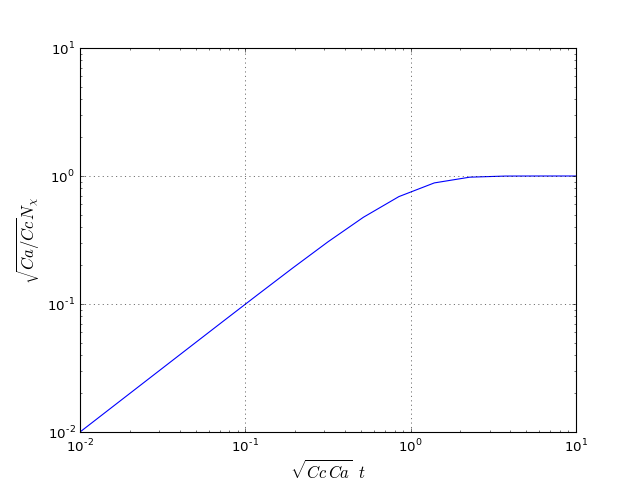

In [15]:
### DONT RUN EVERY TIME ###


fig, ax = plt.subplots()
ax.set_ylabel(r'$\sqrt{Ca/Cc}N_{\chi}$',fontsize=15)
ax.set_xlabel(r'$\sqrt{Cc\,Ca}\,\,\,t$',fontsize=15)
ax.set_xlim([0.01,10])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([0.01,10])
ax.plot(t_array, rut_N)
ax.grid(True)
    

In [16]:
#full_Ca(1000),Cc(1000,vdf.shm_gal,r_sun)

def N_xarray(m,f):
    t_array = np.logspace(-2,2,num=20) 
    cc = Cc(m,f,r_sun)
    can = full_Ca(m)
    def result(t):
        return np.tanh(t) * np.sqrt(cc/can)
    get_result = np.vectorize(result)
    return np.array([t_array,get_result(t_array)])



In [ ]:
### DONT RUN EVERY TIME ###

array1e4 = N_xarray(10000,vdf.shm_gal)
array1e3 = N_xarray(1000,vdf.shm_gal)
array1e2 = N_xarray(100,vdf.shm_gal)
array1e1 = N_xarray(10,vdf.shm_gal)

In [ ]:
### DONT RUN EVERY TIME ###


fig, ax = plt.subplots(figsize=[6,6])
ax.set_ylabel(r'$N_{\chi}$',fontsize=15)
ax.set_xlabel(r'$\sqrt{Cc\,Ca}\,\,\,t$',fontsize=15)
ax.set_xlim([0.01,10])
ax.set_title("Standard Maxwellian\ndistribution", fontsize=20)
#ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([0.01,10])
ax.plot(array1e4[0], array1e4[1],'k--',linewidth=1.5,label=r'm=$1\times 10^4$')
ax.plot(array1e3[0], array1e3[1],'k-*',linewidth=1.5,label=r'm=$1\times 10^3$')
ax.plot(array1e2[0], array1e2[1],'k-.',linewidth=1.5,label=r'm=$1\times 10^2$')
ax.plot(array1e1[0], array1e1[1],'k-',linewidth=1.5,label=r'm=$1\times 10^1$')
ax.grid(True)
legend = ax.legend(loc='upper left', ncol=1, shadow=False, fontsize=13)
frame = legend.get_frame()

In [ ]:

### DONT RUN EVERY TIME ###

mao1e4 = N_xarray(10000,vdf.mao_gal)
mao1e3 = N_xarray(1000,vdf.mao_gal)
mao1e2 = N_xarray(100,vdf.mao_gal)
mao1e1 = N_xarray(10,vdf.mao_gal)

In [ ]:
### DONT RUN EVERY TIME ###

fig, ax = plt.subplots(figsize=[6,6])
ax.set_ylabel(r'$N_{\chi}$',fontsize=15)
ax.set_xlabel(r'$\sqrt{Cc\,Ca}\,\,\,t$',fontsize=15)
ax.set_xlim([0.01,10])
ax.set_title("Mao's empirical\n distribution", fontsize=20)
#ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([0.01,10])
ax.plot(mao1e4[0], mao1e4[1],'b--',linewidth=1.5,label=r'm=$1\times 10^4$')
ax.plot(mao1e3[0], mao1e3[1],'b-*',linewidth=1.5,label=r'm=$1\times 10^3$')
ax.plot(mao1e2[0], mao1e2[1],'b-.',linewidth=1.5,label=r'm=$1\times 10^2$')
ax.plot(mao1e1[0], mao1e1[1],'b-',linewidth=1.5,label=r'm=$1\times 10^1$')
ax.grid(True)
legend = ax.legend(loc='upper left', ncol=1, shadow=False, fontsize=13)
frame = legend.get_frame()

In [ ]:
### DONT RUN EVERY TIME ###

tsa1e4 = N_xarray(10000,vdf.lin_gal)
tsa1e3 = N_xarray(1000,vdf.lin_gal)
tsa1e2 = N_xarray(100,vdf.lin_gal)
tsa1e1 = N_xarray(10,vdf.lin_gal)

In [ ]:
### DONT RUN EVERY TIME ###

fig, ax = plt.subplots(figsize=[6,6])
#ax.set_ylabel(r'$\sqrt{Ca/Cc}N_{\chi}$',fontsize=15)
ax.set_xlabel(r'$\sqrt{Cc\,Ca}\,\,\,t$',fontsize=15)
ax.set_xlim([0.01,10])
ax.set_title("Tsalis distribution", fontsize=20)
#ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([0.01,10])
ax.plot(tsa1e4[0], tsa1e4[1],'r--',linewidth=1.5,label=r'm=$1\times 10^4$')
ax.plot(tsa1e3[0], tsa1e3[1],'r-*',linewidth=1.5,label=r'm=$1\times 10^3$')
ax.plot(tsa1e2[0], tsa1e2[1],'r-.',linewidth=1.5,label=r'm=$1\times 10^2$')
ax.plot(tsa1e1[0], tsa1e1[1],'r-',linewidth=1.5,label=r'm=$1\times 10^1$')
ax.grid(True)
legend = ax.legend(loc='upper left', ncol=1, shadow=False, fontsize=13)
frame = legend.get_frame()

In [ ]:
### DONT RUN EVERY TIME ###

fig, [[ax,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=[12,12])
ax.set_ylabel(r'$N_{\chi}$',fontsize=15)
ax.set_xlabel(r'$\sqrt{Cc\,Ca}\,\,\,t$',fontsize=15)
#ax.set_xlim([0.01,10])

ax.set_xscale('log')
ax.set_ylim([0.0,2e56])
ax.plot(array1e4[0], array1e1[1], 'k-',label='maxwellian')
ax.plot(mao1e4[0], mao1e1[1],'b-',label="Mao's")
ax.plot(tsa1e4[0], tsa1e1[1],'r-',label="Tsallis'")
ax.grid(True)
ax.text(1.5e-2,1.25e56,r'$m_{\chi}=10$ GeV', fontsize=18)

legend = ax.legend(loc='upper left', ncol=1, shadow=False, fontsize=15)


ax2.set_ylabel(r'$N_{\chi}$',fontsize=15)
ax2.set_xlabel(r'$\sqrt{Cc\,Ca}\,\,\,t$',fontsize=15)
ax2.set_xlim([0.01,10])

ax2.set_xscale('log')
ax2.set_ylim([0.0,2e56])
ax2.plot(array1e4[0], array1e2[1], 'k-.',label='maxwellian')
ax2.plot(mao1e4[0], mao1e2[1],'b-.',label="Mao's")
ax2.plot(tsa1e4[0], tsa1e2[1],'r-.',label="Tsallis'")
ax2.grid(True)
ax2.text(1.5e-2,1.25e56,r'$m_{\chi}=100$ GeV', fontsize=18)
legend = ax2.legend(loc='upper left', ncol=1, shadow=False, fontsize=15)



ax3.set_ylabel(r'$N_{\chi}$',fontsize=15)
ax3.set_xlabel(r'$\sqrt{Cc\,Ca}\,\,\,t$',fontsize=15)
ax3.set_xlim([0.01,10])

ax3.set_xscale('log')
ax3.set_ylim([0.0,2e56])
ax3.plot(array1e4[0], array1e3[1], 'k-*',label='maxwellian')
ax3.plot(mao1e4[0], mao1e3[1],'b-*',label="Mao's")
ax3.plot(tsa1e4[0], tsa1e3[1],'r-*',label="Tsallis'")
ax3.grid(True)
ax3.text(1.5e-2,1.25e56,r'$m_{\chi}=1\times10^3$ GeV', fontsize=18)
legend = ax3.legend(loc='upper left', ncol=1, shadow=False, fontsize=15)

ax4.set_ylabel(r'$N_{\chi}$',fontsize=15)
ax4.set_xlabel(r'$\sqrt{Cc\,Ca}\,\,\,t$',fontsize=15)
ax4.set_xlim([0.01,10])

ax4.set_xscale('log')
ax4.set_ylim([0.0,2e56])
ax4.plot(array1e4[0], array1e4[1], 'k--',label='maxwellian')
ax4.plot(mao1e4[0], mao1e4[1],'b--',label="Mao's")
ax4.plot(tsa1e4[0], tsa1e4[1],'r--',label="Tsallis'")
ax4.grid(True)
ax4.text(1.5e-2,1.25e56,r'$m_{\chi}=1\times10^4$ GeV', fontsize=18)
legend = ax4.legend(loc='upper left', ncol=1, shadow=False, fontsize=15)

In [17]:
def N_x_t_fixed(m,f):
    cc = Cc(m,f,r_sun)
    can = full_Ca(m)
    return np.tanh(10) * np.sqrt(cc/can)
get_Ndm =np.vectorize(N_x_t_fixed)


def N_x_by_t(t,f):
    def N_aux(m,f,t):
        cc = Cc(m,f,r_sun)
        can = full_Ca(m)
        return np.tanh(t) * np.sqrt(cc/can)
    vector = np.vectorize(N_aux)
    m_array = np.logspace(1,5,num=5)
    print t
    shm_m = np.array(vector(m_array, vdf.shm_gal,t))
    print shm_m
    func = np.array(vector(m_array, f,t))
    return np.array(func-shm_m)

get_n= np.vectorize(N_x_by_t)
ts = 10.#np.logspace(-2,1, num=1)bb

#mao_t = get_n(ts,vdf.mao_gal)


In [18]:
#mao_t4 = get_n(0.7,vdf.mao_gal)

In [19]:
#m = np.logspace(1,5,num=5)
#print m
#fig, ax = plt.subplots()
#ax.plot(m,mao_t)
#ax.plot(m,mao_t2)
#ax.plot(m,mao_t3) 
#ax.plot(m,mao_t4) 
#ax.set_xscale('log')

In [20]:
m_array = np.logspace(1,5,num=50)
print 'shm'
shm_m = get_Ndm(m_array, vdf.shm_gal)
print 'mao'
mao_m = get_Ndm(m_array, vdf.mao_gal)
print 'Tsa'
tsa_m = get_Ndm(m_array, vdf.lin_gal)


shm


/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


mao
Tsa


In [21]:
anihi = np.vectorize(full_Ca)
anhi_array = anihi(m_array)

In [22]:
fig, (ax, ax1) = plt.subplots(1,2,figsize=[14,7])
ax.set_xscale('log')
ax1.set_xscale('log')
print type(shm_m)
#ax.plot(m_array, shm_m)

ax.grid(True)
ax.set_ylabel(r'$N_x ^{i}\,-N_{x}^{max}$',fontsize=25)
ax.set_xlabel(r'wimp mass [GeV]',fontsize=25)
ax.plot(m_array, (mao_m-shm_m)/shm_m[0], 'b-', linewidth=1.5,label='Mao')
ax.plot(m_array, (tsa_m-shm_m)/shm_m[0], 'r-', linewidth=1.5,label='Tsallis')
legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=15)

zero = np.zeros(len(m_array))
ax.plot(m_array,zero,'k--', linewidth=1.5)
ax1.plot(m_array, anhi_array)

<IPython.core.display.Javascript object>

<type 'numpy.ndarray'>


In [23]:

maofullarray = np.loadtxt('NumData/elout.txt',delimiter=',')
Tsallisfullarray = np.loadtxt('NumData/Tsalisout.txt',delimiter=',')


indices = np.array([0,1,2,3,4])
#print np.concatenate(maofullarray[indices][:,3:])
m = np.logspace(1,5,num=50)#
t= maofullarray[::5,0]



fig, ax = plt.subplots(figsize=[7,5])
ax.set_xscale('log')
ax.set_xlim([10,1e5])
ax.set_ylim([-1.5e28,1.6e28])
Z = [[0,0],[0,0]]
levels = np.linspace(0.01,10,num=50)
CS3 = ax.contourf(Z, t, locator=mpl.ticker.LogLocator(), cmap="Blues")
plt.colorbar(CS3)
CS4 = ax.contourf(Z, t, locator=mpl.ticker.LogLocator(), cmap="Reds")
plt.colorbar(CS4,label=r'$\sqrt{Cc\,Ca}\,\,\,t$')
colors = plt.cm.Blues(np.linspace(0,1,10))
plt.gca().set_color_cycle(colors)


for i in range(0,50,5):
    ax.plot(m,np.concatenate(maofullarray[indices+i][:,3:]))#/shm_m[0])

colors = plt.cm.Reds(np.linspace(0,1,10))
plt.gca().set_color_cycle(colors)
for i in range(0,50,5):
    ax.plot(m,np.concatenate(Tsallisfullarray[indices+i][:,3:]))#/shm_m[0]))

zero = np.zeros(len(m))
ax.plot(m,zero,'k--', linewidth=1.5)

ax.xaxis.set_major_formatter(plt.ScalarFormatter(useOffset=False))
ax.set_title('Variating the\nage of the Sun',fontsize=20)
ax.set_ylabel(r'$N_x ^{i}\,-N_{x}^{max}$',fontsize=20)
ax.set_xlabel(r'wimp mass [GeV]',fontsize=16)


#axMain.yaxis.set_major_formatter(mpt.ScalarFormatter(useOffset=False))

IOError: NumData/elout.txt not found.

In [ ]:
#full_Ca(1000),Cc(1000,vdf.shm_gal,r_sun)

def N_xarray_sq(m,f):
    t_array = np.logspace(3,10,num=40) 
    cc = Cc(m,f,r_sun)*1e-36
    can = full_Ca(m)
    sfac = np.sqrt(cc*can)
    def result(t):
        return np.tanh(sfac*t) * np.sqrt(cc/can)
    get_result = np.vectorize(result)
    return np.array([t_array,get_result(t_array)])

# Now instead of $\sqrt(C Ca)t$ we take $t$

In [ ]:

def squareroot_array(m,f): 
    print m
    cc = Cc(m,f,r_sun)*1e-36
    can = full_Ca(m)
    return np.sqrt(cc*can)
m_array = np.logspace(1,5,num=10)
scuare = np.vectorize(squareroot_array)

In [ ]:
MAXW1e4 = N_xarray_sq(10000,vdf.shm_gal)
MAXW1e3 = N_xarray_sq(1000,vdf.shm_gal)
MAXW1e2 = N_xarray_sq(100,vdf.shm_gal)
MAXW1e1 = N_xarray_sq(10,vdf.shm_gal)

In [ ]:
m_dot = 1.11e57

fig, (ax,ax1)= plt.subplots(1,2,figsize=[14,6])
ax.set_ylabel(r'$N_{\chi}$',fontsize=15)
ax.set_xlabel('t [s]',fontsize=15)
#ax.set_xlim([0.01,10])
ax.set_title("Standard Maxwellian\ndistribution", fontsize=20)
#ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([0.01,10])
ax.plot(MAXW1e4[0], MAXW1e4[1],'k--',linewidth=1.5,label=r'm=$1\times 10^4$')
ax.plot(MAXW1e3[0], MAXW1e3[1],'k-*',linewidth=1.5,label=r'm=$1\times 10^3$')
ax.plot(MAXW1e2[0], MAXW1e2[1],'k-.',linewidth=1.5,label=r'm=$1\times 10^2$')
ax.plot(MAXW1e1[0], MAXW1e1[1],'k-',linewidth=1.5,label=r'm=$1\times 10^1$')
ax.grid(True)
legend = ax.legend(loc='upper left', ncol=1, shadow=False, fontsize=13)
frame = legend.get_frame()

ax1.set_ylabel('Solar mass fraction',fontsize=15)
ax1.set_xlabel('t [s]',fontsize=15)
#ax.set_xlim([0.01,10])
ax1.set_title("Standard Maxwellian\ndistribution", fontsize=20)
ax1.set_yscale('log')
ax1.set_xscale('log')
#ax.set_ylim([0.01,10])
ax1.plot(MAXW1e4[0], MAXW1e4[1]*1e4/m_dot,'k--',linewidth=1.5,label=r'm=$1\times 10^4$')
ax1.plot(MAXW1e3[0], MAXW1e3[1]*1e3/m_dot,'k-*',linewidth=1.5,label=r'm=$1\times 10^3$')
ax1.plot(MAXW1e2[0], MAXW1e2[1]*1e2/m_dot,'k-.',linewidth=1.5,label=r'm=$1\times 10^2$')
ax1.plot(MAXW1e1[0], MAXW1e1[1]/m_dot,'k-',linewidth=1.5,label=r'm=$1\times 10^1$')
ax1.grid(True)
legend = ax1.legend(loc='upper left', ncol=1, shadow=False, fontsize=13)
frame = legend.get_frame()

In [ ]:


### DONT RUN EVERY TIME ###

Mao1e4 = N_xarray_sq(10000,vdf.mao_gal)
Mao1e3 = N_xarray_sq(1000,vdf.mao_gal)
Mao1e2 = N_xarray_sq(100,vdf.mao_gal)
Mao1e1 = N_xarray_sq(10,vdf.mao_gal)

In [ ]:
### DONT RUN EVERY TIME ###

fig, (ax,ax1)= plt.subplots(1,2,figsize=[14,6])
ax.set_ylabel(r'$N_{\chi}$',fontsize=15)
ax.set_xlabel('t [s]',fontsize=15)
#ax.set_xlim([0.01,10])
ax.set_title("Mao's empirical\n distribution", fontsize=20)
#ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([0.01,10])
ax.plot(Mao1e4[0], Mao1e4[1],'b--',linewidth=1.5,label=r'm=$1\times 10^4$')
ax.plot(Mao1e3[0], Mao1e3[1],'b-*',linewidth=1.5,label=r'm=$1\times 10^3$')
ax.plot(Mao1e2[0], Mao1e2[1],'b-.',linewidth=1.5,label=r'm=$1\times 10^2$')
ax.plot(Mao1e1[0], Mao1e1[1],'b-',linewidth=1.5,label=r'm=$1\times 10^1$')
ax.grid(True)
legend = ax.legend(loc='upper left', ncol=1, shadow=False, fontsize=13)
frame = legend.get_frame()


ax1.set_ylabel('Solar mass fraction',fontsize=15)
ax1.set_xlabel('t [s]',fontsize=15)
#ax.set_xlim([0.01,10])
ax1.set_title("Mao's empirical\n distribution", fontsize=20)
ax1.set_yscale('log')
ax1.set_xscale('log')
#ax.set_ylim([0.01,10])
ax1.plot(Mao1e4[0], Mao1e4[1]*1e4/m_dot,'b--',linewidth=1.5,label=r'm=$1\times 10^4$')
ax1.plot(Mao1e3[0], Mao1e3[1]*1e3/m_dot,'b-*',linewidth=1.5,label=r'm=$1\times 10^3$')
ax1.plot(Mao1e2[0], Mao1e2[1]*1e2/m_dot,'b-.',linewidth=1.5,label=r'm=$1\times 10^2$')
ax1.plot(Mao1e1[0], Mao1e1[1]/m_dot,'b-',linewidth=1.5,label=r'm=$1\times 10^1$')
ax1.grid(True)
legend = ax1.legend(loc='upper left', ncol=1, shadow=False, fontsize=13)
frame = legend.get_frame()

In [ ]:
### DONT RUN EVERY TIME ###

Tsa1e4 = N_xarray_sq(10000,vdf.lin_gal)
Tsa1e3 = N_xarray_sq(1000,vdf.lin_gal)
Tsa1e2 = N_xarray_sq(100,vdf.lin_gal)
Tsa1e1 = N_xarray_sq(10,vdf.lin_gal)

In [ ]:
### DONT RUN EVERY TIME ###

fig, (ax,ax1)= plt.subplots(1,2,figsize=[14,6])
ax.set_ylabel(r'$N_{\chi}$',fontsize=15)
ax.set_xlabel('t  [s]',fontsize=15)
#x.set_xlim([0.01,10])
ax.set_title("Tsalis distribution", fontsize=20)
#ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([0.01,10])
ax.plot(Tsa1e4[0], Tsa1e4[1],'r--',linewidth=1.5,label=r'm=$1\times 10^4$')
ax.plot(Tsa1e3[0], Tsa1e3[1],'r-*',linewidth=1.5,label=r'm=$1\times 10^3$')
ax.plot(Tsa1e2[0], Tsa1e2[1],'r-.',linewidth=1.5,label=r'm=$1\times 10^2$')
ax.plot(Tsa1e1[0], Tsa1e1[1],'r-',linewidth=1.5,label=r'm=$1\times 10^1$')
ax.grid(True)
legend = ax.legend(loc='upper left', ncol=1, shadow=False, fontsize=13)
frame = legend.get_frame()


ax1.set_ylabel('Solar mass fraction',fontsize=15)
ax1.set_xlabel('t  [s]',fontsize=15)
#x.set_xlim([0.01,10])
ax1.set_title("Tsalis distribution", fontsize=20)
ax1.set_yscale('log')
ax1.set_xscale('log')
#ax.set_ylim([0.01,10])
ax1.plot(Tsa1e4[0], Tsa1e4[1]*1e4/m_dot,'r--',linewidth=1.5,label=r'm=$1\times 10^4$')
ax1.plot(Tsa1e3[0], Tsa1e3[1]*1e3/m_dot,'r-*',linewidth=1.5,label=r'm=$1\times 10^3$')
ax1.plot(Tsa1e2[0], Tsa1e2[1]*1e2/m_dot,'r-.',linewidth=1.5,label=r'm=$1\times 10^2$')
ax1.plot(Tsa1e1[0], Tsa1e1[1]/m_dot,'r-',linewidth=1.5,label=r'm=$1\times 10^1$')
ax1.grid(True)
legend = ax1.legend(loc='upper left', ncol=1, shadow=False, fontsize=13)
frame = legend.get_frame()

In [ ]:
### DONT RUN EVERY TIME ###

fig, [[ax,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=[12,12])
ax.set_ylabel(r'$N_{\chi}$',fontsize=15)
ax.set_xlabel(r'$\sqrt{Cc\,Ca}\,\,\,t$',fontsize=15)
#x.set_xlim([0.01,10])

ax.set_xscale('log')
#ax.set_ylim([0.0,2.6e38])
ax.plot(MAXW1e4[0], MAXW1e1[1], 'k-',label='maxwellian')
ax.plot(Mao1e4[0], Mao1e1[1],'b-',label="Mao's")
ax.plot(Tsa1e4[0], Tsa1e1[1],'r-',label="Tsallis'")
ax.grid(True)
ax.text(1.5e8,1.25e38,r'$m_{\chi}=10$ GeV', fontsize=18)

legend = ax.legend(loc='upper left', ncol=1, shadow=False, fontsize=15)


ax2.set_ylabel(r'$N_{\chi}$',fontsize=15)
ax2.set_xlabel(r'$\sqrt{Cc\,Ca}\,\,\,t$',fontsize=15)
#x2.set_xlim([0.01,10])

ax2.set_xscale('log')
ax2.set_ylim([0.0,2.6e38])
ax2.plot(MAXW1e4[0], MAXW1e2[1], 'k-.',label='maxwellian')
ax2.plot(Mao1e4[0], Mao1e2[1],'b-.',label="Mao's")
ax2.plot(Tsa1e4[0], Tsa1e2[1],'r-.',label="Tsallis'")
ax2.grid(True)
ax2.text(1.5e8,1.25e38,r'$m_{\chi}=100$ GeV', fontsize=18)
legend = ax2.legend(loc='upper left', ncol=1, shadow=False, fontsize=15)



ax3.set_ylabel(r'$N_{\chi}$',fontsize=15)
ax3.set_xlabel(r'$\sqrt{Cc\,Ca}\,\,\,t$',fontsize=15)
#ax3.set_xlim([0.01,10])

ax3.set_xscale('log')
ax3.set_ylim([0.0,2.6e38])
ax3.plot(MAXW1e4[0], MAXW1e3[1], 'k-*',label='maxwellian')
ax3.plot(Mao1e4[0], Mao1e3[1],'b-*',label="Mao's")
ax3.plot(Tsa1e4[0], Tsa1e3[1],'r-*',label="Tsallis'")
ax3.grid(True)
ax3.text(1.5e8,1.25e38,r'$m_{\chi}=1\times10^3$ GeV', fontsize=18)
legend = ax3.legend(loc='upper left', ncol=1, shadow=False, fontsize=15)

ax4.set_ylabel(r'$N_{\chi}$',fontsize=15)
ax4.set_xlabel(r'$\sqrt{Cc\,Ca}\,\,\,t$',fontsize=15)
#ax4.set_xlim([0.01,10])

ax4.set_xscale('log')
ax4.set_ylim([0.0,2.6e38])
ax4.plot(MAXW1e4[0], MAXW1e4[1], 'k--',label='maxwellian')
ax4.plot(Mao1e4[0], Mao1e4[1],'b--',label="Mao's")
ax4.plot(Tsa1e4[0], Tsa1e4[1],'r--',label="Tsallis'")
ax4.grid(True)
ax4.text(1.5e8,1.25e38,r'$m_{\chi}=1\times10^4$ GeV', fontsize=18)
legend = ax4.legend(loc='upper left', ncol=1, shadow=False, fontsize=15)

In [ ]:
mao_sqrfactor=scuare(m_array,vdf.mao_gal)

In [ ]:
lin_sqrfactor=scuare(m_array,vdf.lin_gal)

In [ ]:
shm_sqrfactor=scuare(m_array,vdf.shm_gal)

In [ ]:
fig, ax =plt.subplots()
ax.plot(m_array,mao_sqrfactor)
ax.plot(m_array,lin_sqrfactor)
ax.plot(m_array,shm_sqrfactor)
ax.set_xscale('log')

In [ ]:

maofullarray = np.loadtxt('NumData/Maoout.txt',delimiter=',')
Tsallisfullarray = np.loadtxt('NumData/Tsa_out.txt',delimiter=',')


indices = np.array([0,1,2,3,4])
#print np.concatenate(maofullarray[indices][:,3:])
m = np.logspace(1,5,num=50)#
t= maofullarray[::5,0]



fig, ax = plt.subplots(figsize=[7,5])
ax.set_xscale('log')
ax.set_xlim([10,1e5])
ax.set_ylim([-.9e37,1.25e37])
Z = [[0,0],[0,0]]
levels = np.linspace(0.01,10,num=50)

CS3 = ax.contourf(Z, t, locator=mpl.ticker.LogLocator(), cmap="Blues")
plt.colorbar(CS3)
CS4 = ax.contourf(Z, t, locator=mpl.ticker.LogLocator(), cmap="Reds")
plt.colorbar(CS4,label="Sun's age")
colors = plt.cm.Blues(np.linspace(0,1,10))
plt.gca().set_color_cycle(colors)


for i in range(0,50,5):
    ax.plot(m,np.concatenate(maofullarray[indices+i][:,3:]))#/shm_m[0])

colors = plt.cm.Reds(np.linspace(0,1,10))
plt.gca().set_color_cycle(colors)
for i in range(0,50,5):
    ax.plot(m,np.concatenate(Tsallisfullarray[indices+i][:,3:]))#/shm_m[0]))

zero = np.zeros(len(m))
ax.plot(m,zero,'k--', linewidth=1.5)

ax.xaxis.set_major_formatter(plt.ScalarFormatter(useOffset=False))
ax.set_title('Variating the\nage of the Sun',fontsize=20)
ax.set_ylabel(r'$N_x ^{i}\,-N_{x}^{max}$',fontsize=20)
ax.set_xlabel(r'wimp mass [GeV]',fontsize=16)


#axMain.yaxis.set_major_formatter(mpt.ScalarFormatter(useOffset=False))